In [3]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.gridspec import GridSpec
plt.rcParams['font.family'] = ['Arial']
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.unicode_minus'] = False

def delete_files_in_folder(folder_path):
    try:
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)
    except Exception as e:
        print(f"删除文件时出错: {e}")

In [4]:
regionS, folder = dict(), 'static_infos'
columns2keep = {
    'Invasion': '#54B345',
    'Herbicide control': '#8E8BFE',
    'Mowing 1st': '#C82423',
    'Waterlogging': '#547BB4',
    'WL_fast': '#547BB4',
    'Mowing 2nd': '#BB9727',
    'Recurring': '#6F6F6F',
    'date': None,
    'No change': None,
    'removal_rate': None
}
provinces = ['SD', 'JS', 'SH', 'ZJ', 'FJ', 'GDGX']
# Clipped to 2022
provincely_area = [8706.15, 19028.48, 15407.28, 18115.83, 7491.06, 231.82]  # Static date range
# not Clipped
# provincely_area = [10902.65, 29404.11, 20878.88, 28593.03, 12150.38, 1768.82]
for file in os.listdir(folder):
    if file == 'imgs': continue
    file_path = os.path.join(folder, file)
    raw_data = pd.read_csv(file_path)
    region = raw_data['region'].head().values[0]
    raw_data['date'] = pd.to_datetime(raw_data['date'])
    raw_data['removal_rate'] = None
    regionS.update({region: raw_data[columns2keep.keys()]})

for area, province in zip(provincely_area, provinces):

    dates = regionS[province]['date']

    removal = regionS[province][['Herbicide control', 'Mowing 1st', 'Mowing 2nd', 'WL_fast']].sum(axis=1)
    recurring = regionS[province]['Recurring']
    const_calc = removal - recurring    # constant part
    
    invasion = regionS[province]['Invasion']    # float part
    invasion_total = invasion.sum()
    
    const_tf, const_wb = regionS[province]['No change'].iloc[0], \
                         regionS[province]['No change'].iloc[1]
    SA = area - const_tf - const_wb - invasion_total
    new_df = pd.DataFrame({
        'date': dates,
        'const_calc': const_calc,
        'invasion': invasion,
        'removal_rate': None
    })
    monthly_invasion, monthly_const_calc = 0, 0
    for idx, row in new_df.iterrows():
        monthly_invasion, monthly_const_calc = monthly_invasion + row['invasion'], \
                                               monthly_const_calc + row['const_calc']
        removal_rate = ((SA + monthly_invasion) - monthly_const_calc) / (SA + monthly_invasion)
        removal_rate = 1 - removal_rate
        new_df.loc[idx, 'removal_rate'] = removal_rate * 100
    regionS[province].loc[:, 'removal_rate'] = new_df['removal_rate']
    
    province_data = regionS[province]
    print(f'province: {province}, area: {area:.2f} ha - {area * 15:.2f} mu')
    start_date, end_date = pd.to_datetime('2023-01-01'), pd.to_datetime('2024-01-01')
    mask = (province_data['date'] >= start_date) & (province_data['date'] <= end_date)
    print(f'date range: {start_date.date()} to {end_date.date()}')
    filtered_data = province_data[mask]
    # 计算三列总和（Mowing 1st + Mowing 2nd + Herbicide control）
    sum_mowing_herb = filtered_data[['Mowing 1st', 'Mowing 2nd', 'Herbicide control', 'WL_fast']].sum().sum()
    [print(f'{evt}:\t\t|{filtered_data[evt].sum():.2f}|ha - {filtered_data[evt].sum() * 15:.2f} mu') \
        for evt in ['Mowing 1st', 'Mowing 2nd', 'Herbicide control', 'WL_fast']]
    final_removal_rate = filtered_data['removal_rate'].iloc[-1]
    
    print(f'removal sum: \t\t|{sum_mowing_herb:.2f}|ha - {sum_mowing_herb * 15:.2f} mu')
    print(f'final removal rate: \t|{final_removal_rate:.2f}|%')
    print('=' * 50)

province: SD, area: 8706.15 ha - 130592.25 mu
date range: 2023-01-01 to 2024-01-01
Mowing 1st:		|957.31|ha - 14359.62 mu
Mowing 2nd:		|91.59|ha - 1373.83 mu
Herbicide control:		|0.04|ha - 0.60 mu
WL_fast:		|27.33|ha - 410.00 mu
removal sum: 		|1076.27|ha - 16144.04 mu
final removal rate: 	|96.02|%
province: JS, area: 19028.48 ha - 285427.20 mu
date range: 2023-01-01 to 2024-01-01
Mowing 1st:		|7399.32|ha - 110989.80 mu
Mowing 2nd:		|277.96|ha - 4169.39 mu
Herbicide control:		|27.88|ha - 418.13 mu
WL_fast:		|2214.54|ha - 33218.09 mu
removal sum: 		|9919.69|ha - 148795.41 mu
final removal rate: 	|57.06|%
province: SH, area: 15407.28 ha - 231109.20 mu
date range: 2023-01-01 to 2024-01-01
Mowing 1st:		|640.44|ha - 9606.65 mu
Mowing 2nd:		|58.29|ha - 874.32 mu
Herbicide control:		|353.95|ha - 5309.28 mu
WL_fast:		|3.26|ha - 48.92 mu
removal sum: 		|1055.94|ha - 15839.17 mu
final removal rate: 	|8.47|%
province: ZJ, area: 18115.83 ha - 271737.45 mu
date range: 2023-01-01 to 2024-01-01
Mowing

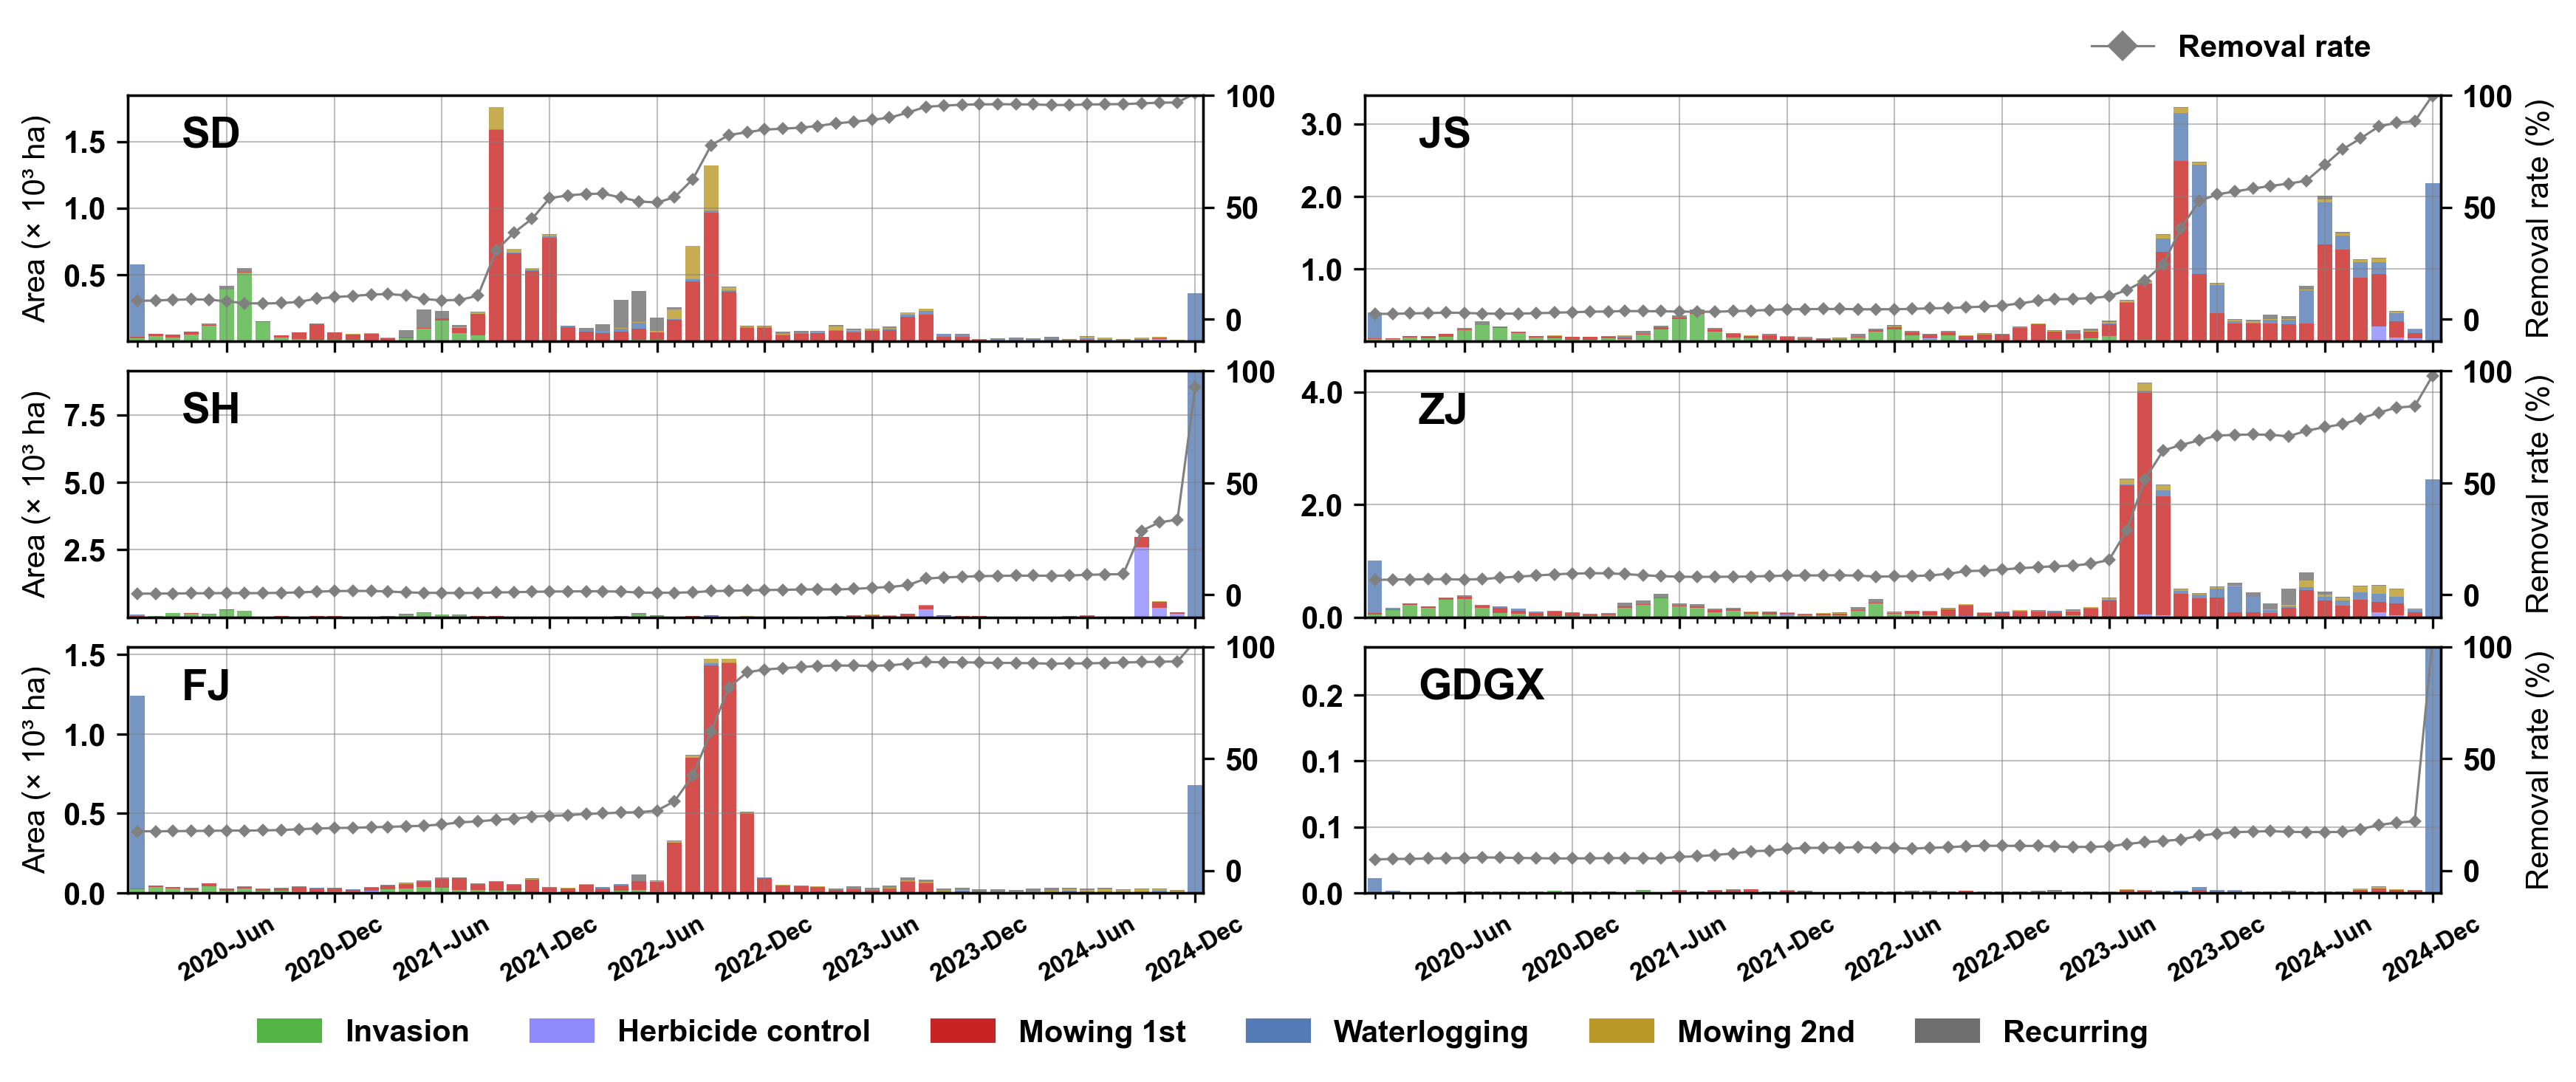

In [5]:
import matplotlib.patches as mpatches
for region in regionS.keys():
    delete_files_in_folder('./static_infos/imgs')
    
n_cols, global_legends = 2, None
n_rows = (len(provinces) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 1.5 * n_rows), dpi=300)
fig.subplots_adjust(hspace=0.6)

for idx, province in enumerate(provinces):
    i, j = idx // n_cols, idx % n_cols
    ax = axs[i, j]
    ax2 = ax.twinx()    # removal_rate ax
    bar_bottom, legends = None, list()
    
    region2show = regionS[province]
    for idx_evt, evt in enumerate(columns2keep.keys()):
        if evt == 'date' or evt == 'No change': continue
        if evt == 'removal_rate':
            ax2.plot(region2show['date'], region2show[evt], 
                     label='Removal rate',
                     markersize=2, marker='D', 
                     linestyle='-', linewidth=0.75, color='grey'
                     )
            ax2.set_ylim(-10, 100)
            continue
        ax.bar(region2show['date'], region2show[evt] / 1000, bottom=bar_bottom, \
               color=list(columns2keep.values())[idx_evt], alpha=0.8, width=25, label=evt)
        if evt != 'WL_fast':
            legends.append(mpatches.Patch(color=list(columns2keep.values())[idx_evt], label=evt))
            
        bar_bottom = bar_bottom + region2show[evt] / 1000 if bar_bottom is not None else region2show[evt] / 1000
        
    boundary_top = int(bar_bottom.max() * 1.05)
    boundary_top = boundary_top if boundary_top >= 0.1 else 0.1
    
    from matplotlib.ticker import FormatStrFormatter  
    # ax.set_ylim(0, boundary_top)
    ax.set_xlim(pd.Timestamp('2019-12-15'), pd.Timestamp('2024-12-15'))
    if j == 0: ax.set_ylabel('Area (× 10³ ha)')
    else: 
        ax.set_ylabel('') # Hide y-axis label for subplots in the second column
        ax2.set_ylabel('Removal rate (%)')
    if i != n_rows - 1: ax.tick_params(axis='x', labelbottom=False) # Hide x-axis label for subplots in the first row
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

    ax.set_xlim(pd.Timestamp('2019-12-15'), pd.Timestamp('2024-12-15'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    if i != n_rows - 1: # Hide x-axis label except for the bottom row
        ax.tick_params(axis='x', labelbottom=False, which='major')
        ax.tick_params(axis='x', labelbottom=False, which='minor')
    else:
        ax.tick_params(axis='x', rotation=30, labelsize=8, length=3, labelbottom=True, which='major')
        
    if idx == 0 : global_legends = legends.copy()
    ax.grid(which='major', linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
    ax.text(
        ax.get_xlim()[0] * 1.005, 
        ax.get_ylim()[1] * 0.75, f'{province}',
        ha='left', va='bottom',
        fontsize=14,
        fontweight='bold',
    )
if len(provinces) % n_cols != 0:
    axs[-1, -1].axis('off')

if global_legends is not None:
    ax.legend(
        handles=legends, 
        bbox_to_anchor=(-0.15, -0.4),
        ncol=len(global_legends),
        frameon=False,
        markerscale=1.5,
        loc='upper center')
    ax2.legend(
        bbox_to_anchor=(0.65, 3.6),
        frameon=False,
        loc='upper left',
        markerscale=3
    )
    
fig.subplots_adjust(
    hspace=0.12,   # 垂直间距从0.6缩小到0.3（根据实际效果调整）
    wspace=0.15,  # 新增水平间距控制（默认较大，缩小为0.15）
    left=0.08,    # 左边距缩小（原默认0.125）
    right=0.95,   # 右边距扩大（减少右侧空白）
    top=0.95,     # 顶部边距缩小（减少顶部空白）
    bottom=0.15   # 底部边距调整（配合图例位置）
)
plt.show()